In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from scipy import ndimage
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
from skimage.draw import circle

In [3]:
def create_1d_gaussian_kernel(t):
    return signal.gaussian(np.ceil(2 * 3 * t ** 0.5 + 1), std=t ** 0.5)

Derive (analytically) the second order derivative of the Gaussian

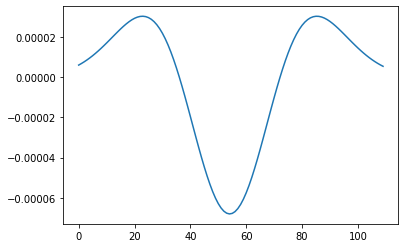

In [4]:
def analytical_2nd_gaussian_1d(t,multiplier=3):
    sigma = t**0.5
    window_size = multiplier*sigma 
    x = np.arange(-window_size,window_size+1,1)
    dd_gauss = -(((sigma ** 2) - x ** 2) / ((sigma ** 5) * np.sqrt(2 * np.pi))) * np.exp(-(x ** 2) / (2 * sigma ** 2))
    return dd_gauss

def gaussian_1d(t,multiplier=3):
    sigma = t**0.5
    window_size = int(multiplier*sigma) 
    vector_size = int(np.ceil(window_size*2+1))
    x = np.arange(-window_size,window_size+1,1)
    gauss = signal.gaussian(vector_size, std=sigma)
    return gauss
    
plt.plot(analytical_2nd_gaussian_1d(325))

Implement a function that takes the variance t as input and outputs
a filter kernel of g and $\frac{d^2g}{dx^2}$. You should use a filter kernel of at least 3t. Why?
<hr>
This is because t is the varance and 3t should make the window large enough so that we get most of the effect of the filter within the window. As we go farther than 3/2t to either side, the effect of the window would be negligable. 


#### 3. Try the function on the synthetic test image test_blob_uniform.png

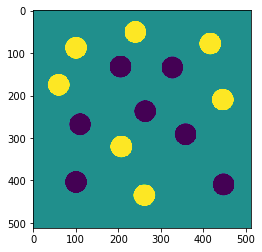

In [5]:
image = plt.imread('./EX_2_data/test_blob_uniform.png')
plt.imshow(image)
plt.show()

In [6]:
def convolve_with_1d_kernel(image, kernel):
    convolved_first = ndimage.convolve(image, [kernel], mode='nearest', cval=0.0)
    convolved_second = ndimage.convolve(convolved_first.T, [kernel], mode='nearest', cval=0.0).T
    return convolved_second

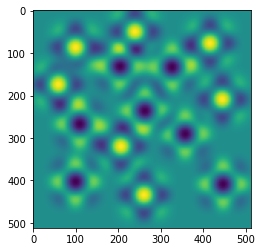

In [7]:
kernel = analytical_2nd_gaussian_1d(325)
convolved = convolve_with_1d_kernel(image,kernel)
plt.imshow(convolved)

# 2.1.2 Detecting blobs on one scale


## 1. Compute the Laplacian at one scale using the synthetic test image <code>test_blob_uniform.png</code>

In [8]:
def Laplacian(img, t):
    
    dd_gaussian_kernel = analytical_2nd_gaussian_1d(t)
    gaussian_kernel = gaussian_1d(t)
    
    Lxx = ndimage.convolve(img, np.array([dd_gaussian_kernel]), mode='nearest', cval=0.0)
    Lxx = ndimage.convolve(Lxx, np.array([gaussian_kernel]).T, mode='nearest', cval=0.0)
    
    Lyy = ndimage.convolve(img, np.array([dd_gaussian_kernel]).T, mode='nearest', cval=0.0)
    Lyy = ndimage.convolve(Lyy, np.array([gaussian_kernel]), mode='nearest', cval=0.0)
    
    L = Lxx+Lyy
    
    return L,Lxx,Lyy

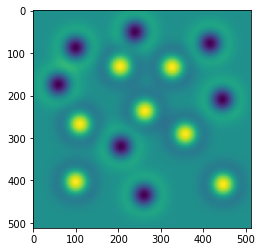

In [9]:
t = 325
L,Lxx,Lyy = Laplacian(image,t) 
plt.imshow(L)
plt.show()

## 2. Build a function that detects the coordinates of maxima and minima in the Laplacian image (detect blobs).
<hr>

### Notes:

<li> What matters this case is finding <b>local</b> minima/maxima. That means that a point is smaller/larger than all of its neighbours. This can only happen at the point of minima/maxima  

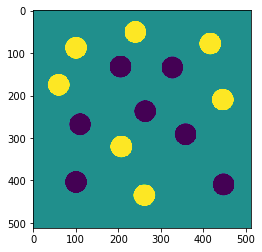

In [10]:
plt.imshow(image)

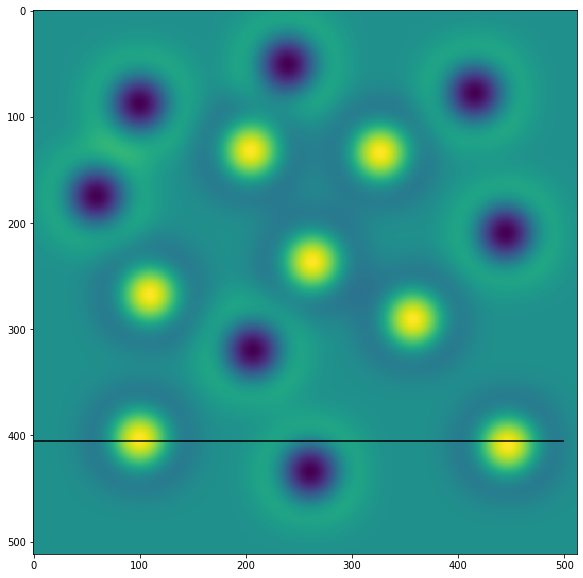

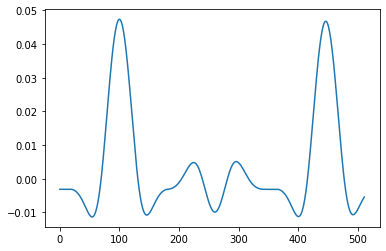

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(L)
plt.hlines(405,0,500)
plt.show()
plt.plot(L[405])
plt.show()


We see there are small local minima and local maxima to be found in the vicinity of the blobs we are trying to detect. so we must implement a threshold to avoid detecting these points. 

In [12]:
def make_window_stack(L,size):
    shift_h,shift_v = np.arange(-size,size+1),np.arange(-size,size+1)
    new_dim = tuple([i - 2*size for i in L.shape])
    window_stack = []
    window_stack.append(L)
    for h in shift_h:
        for v in shift_v:
            if (v != 0) | (h != 0):
                new_stack = np.roll(np.roll(L,v,axis=0),h,axis=1)

            window_stack.append(new_stack)
            
    return np.array(window_stack)
    
    
def find_min_max(L,win_size,rel_thresh):
    window_stack = make_window_stack(L,win_size)
    img_max = np.max(L)
    img_min = np.min(L)
    min_points = [(window_stack[0]<tmp_window) & (window_stack[0] < img_min*rel_thresh) for tmp_window in window_stack[1:]]
    max_points = [(window_stack[0]>tmp_window) & (window_stack[0] > img_max*rel_thresh) for tmp_window in window_stack[1:]]
    mins = np.sum(min_points,axis=0)==(win_size*2+1)**2
    maxs = np.sum(max_points,axis=0)==(win_size*2+1)**2
    return mins,maxs

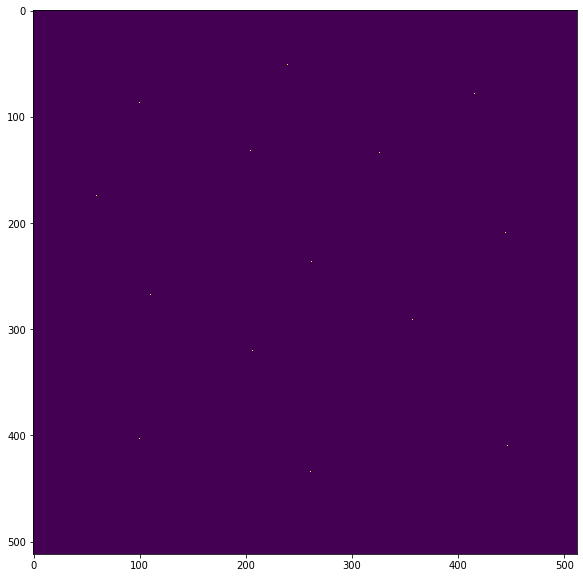

In [13]:
L_min,L_max = find_min_max(L,2,0.6)
L_min_max = (L_min+L_max)*1
plt.figure(figsize=(10,10))
plt.imshow(L_min_max)
plt.show()


## Plot the center coordinates and circles outlining the detected blobs. The radius of the circles should be ${\sqrt{2t}}$

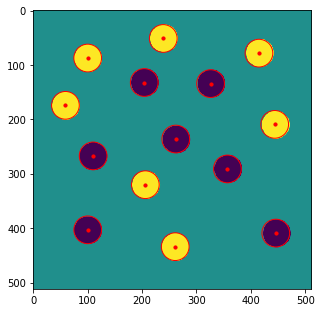

In [14]:
from matplotlib.patches import Circle

coordinates = np.argwhere(L_min_max == 1)
f,ax = plt.subplots(1,1, figsize=(5.12,5.12))
plt.imshow(image)
plt.scatter(coordinates[:,1],coordinates[:,0],c='red',s=10)
for yy,xx in coordinates:
    circ = Circle((xx,yy),np.sqrt(2*t), edgecolor='red', facecolor='None', fill=False)
    ax.add_patch(circ)
    
plt.show()

# Detecting blobs on multiple scales

1. Decide on scales at which the Laplacian must be computed. You could make it equal steps in the size of the blobs (√2t).

In [15]:
# We will try values from 1-10 multiples of sqrt(2t)

def make_steps(t,n):
    steps = [int(np.sqrt(2*t)*i) for i in range(0,n)]
    return steps

2. Compute the scale normalized scale-space Laplacian ${t\nabla^2 L}$ for the test image test_blob_uniform.png.

In [16]:
def perform_2d_gaussian(image,t):
    g_1d = gaussian_1d(t)
    tmp_image = ndimage.convolve(image,[g_1d])
    tmp_image = ndimage.convolve(tmp_image,np.array([g_1d]).T)
    return tmp_image

In [17]:
n = 25
steps = make_steps(t,n)

SS_L = []
for i in steps:
    print('t:',i,' - ',end='')
    tmp_L, _, _ = Laplacian(image,i)
    SS_L.append(i*tmp_L)
    
SS_L = np.array(SS_L)

t: 0  - t: 25  - t: 50  - t: 76  - t: 101  - t: 127  - 

/Users/paweldarulewski/Documents/DTU/1_sem/02506 Advanced Image Analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


t: 152  - t: 178  - t: 203  - t: 229  - t: 254  - t: 280  - t: 305  - t: 331  - t: 356  - t: 382  - t: 407  - t: 433  - t: 458  - t: 484  - t: 509  - t: 535  - t: 560  - t: 586  - t: 611  - 

In [18]:
SS_L.shape

(25, 512, 512)

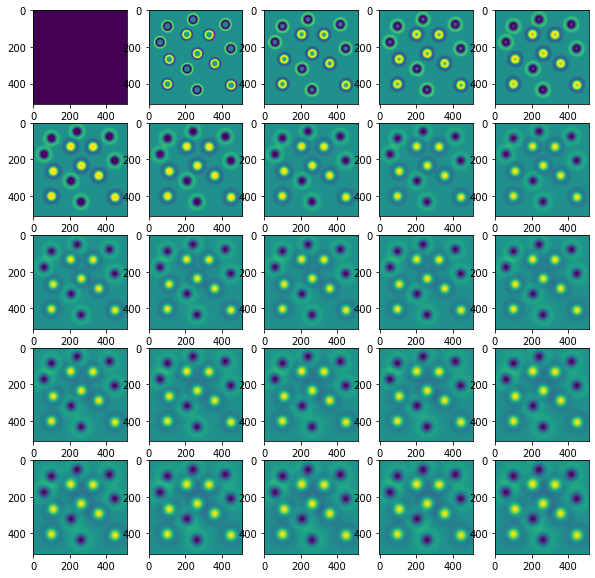

In [19]:
f,axes = plt.subplots(5,5, figsize=(10,10))
axes = np.ravel(axes)
for b,ax in zip(SS_L,axes):
    ax.imshow(b)

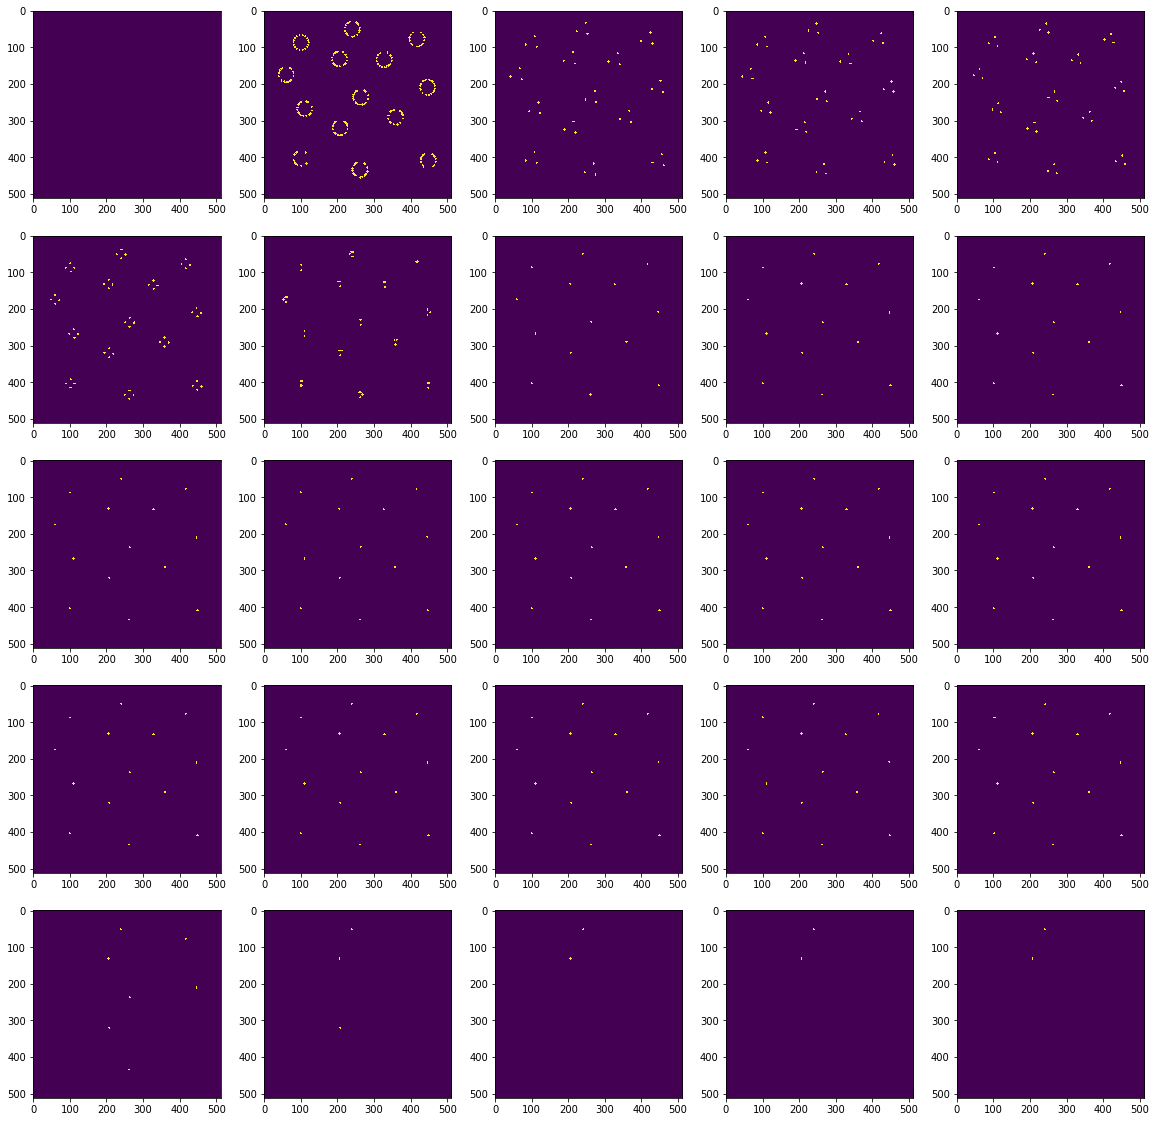

In [20]:
f,axes = plt.subplots(5, 5, figsize=(20, 20))
axes = np.ravel(axes)
for b, ax in zip(SS_L,axes):
    mins, maxs = find_min_max(b, 2, 0.99)
    min_max = (mins + maxs) * 1
    min_max = ndimage.morphology.binary_dilation(min_max, iterations=3)
    ax.imshow(min_max)

In [22]:
im_SEM = plt.imread('./EX_2_data/CT_synchrotron.png')[400:600,400:600]

In [23]:
t = 25
# Run Laplace on image
L_SEM,Lxx_SEM,Lyy_SEM = Laplacian(im_SEM,t) 
# Perform blob detection
min_SEM,max_SEM = find_min_max(L_SEM,3,0.4)
# Get coordinates of blobs
min_coords_SEM = np.argwhere(min_SEM==1)
max_coords_SEM = np.argwhere(max_SEM==1)

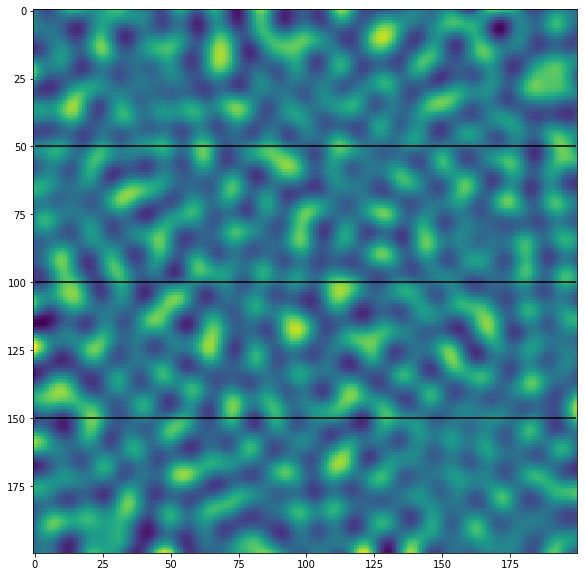

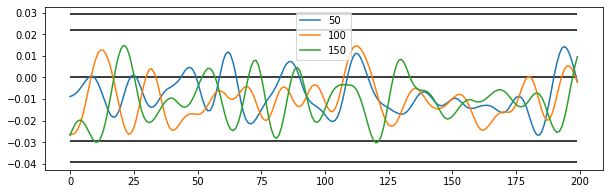

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(L_SEM)
plt.hlines([50,100,150],0,199)
plt.show()
plt.figure(figsize=(10,3))
plt.plot(L_SEM[50])
plt.plot(L_SEM[100])
plt.plot(L_SEM[150])
plt.legend([50,100,150])
plt.hlines([0,np.min(L_SEM),np.max(L_SEM),np.min(L_SEM)*0.75,np.max(L_SEM)*0.75],0,199)
plt.show()

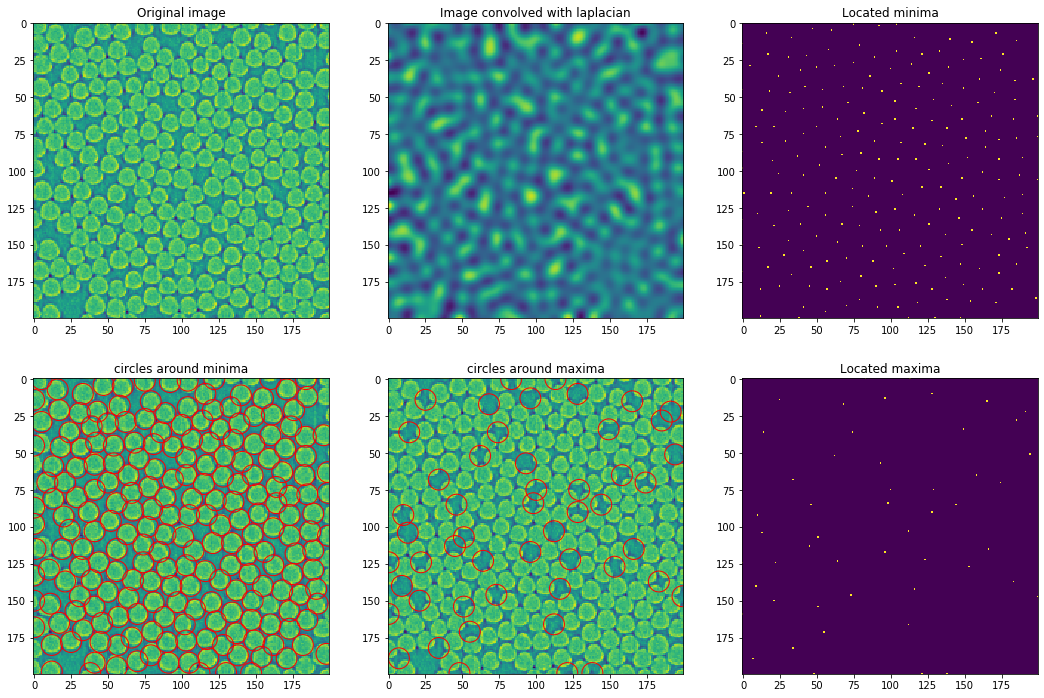

In [25]:
f,ax = plt.subplots(2,3, figsize=(18,12))
ax = np.ravel(ax)
for _ax in ax:
    _ax.set_aspect('equal')
ax[0].imshow(im_SEM)
ax[0].set_title('Original image')
ax[1].imshow(L_SEM)
ax[1].set_title('Image convolved with laplacian')
ax[2].imshow(min_SEM)
ax[2].set_title('Located minima')
ax[5].imshow(max_SEM)
ax[5].set_title('Located maxima')

ax[3].imshow(im_SEM)
ax[3].set_title('circles around minima')
for yy,xx in min_coords_SEM:
#     print(yy,xx)
    circ = Circle((xx,yy),np.sqrt(2*t), edgecolor='red', facecolor='None', fill=False)
    ax[3].add_patch(circ)
    
ax[4].imshow(im_SEM)
ax[4].set_title('circles around maxima')
for yy,xx in max_coords_SEM:
#     print(yy,xx)
    circ = Circle((xx,yy),np.sqrt(2*t), edgecolor='red', facecolor='None', fill=False)
    ax[4].add_patch(circ)

### 2.1.5 Localize blobs

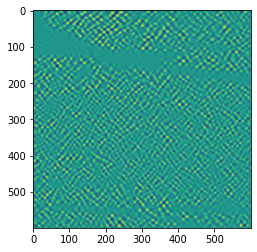

In [26]:
image = plt.imread('./EX_2_data/CT_lab_med_res.png')
kernel = analytical_2nd_gaussian_1d(20)
convolved = convolve_with_1d_kernel(image, kernel)
plt.imshow(convolved)


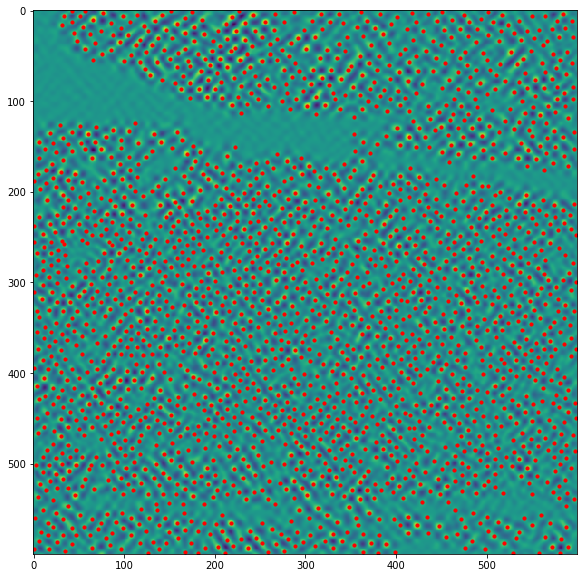

In [27]:
mins, maxs = find_min_max(convolved, 2, 0.2)
mins = (mins) * 1
maxs = (maxs) * 1

coordinates_mins = np.argwhere(mins==1)
coordinates_maxs = np.argwhere(maxs==1)

plt.figure(figsize=(10,10))
plt.scatter(coordinates_maxs[:,1], coordinates_maxs[:,0], c='red', marker='o',  s=10)
plt.imshow(convolved)


In [28]:
n = 25
steps = make_steps(t,n)

SS_L = []
for i in steps:
    print('t:',i,' - ',end='')
    tmp_L, _, _ = Laplacian(convolved, i)
    SS_L.append(i * tmp_L)
    
SS_L = np.array(SS_L)

t: 0  - t: 7  - t: 14  - t: 21  - t: 28  - t: 35  - 

/Users/paweldarulewski/Documents/DTU/1_sem/02506 Advanced Image Analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


t: 42  - t: 49  - t: 56  - t: 63  - t: 70  - t: 77  - t: 84  - t: 91  - t: 98  - t: 106  - t: 113  - t: 120  - t: 127  - t: 134  - t: 141  - t: 148  - t: 155  - t: 162  - t: 169  - 

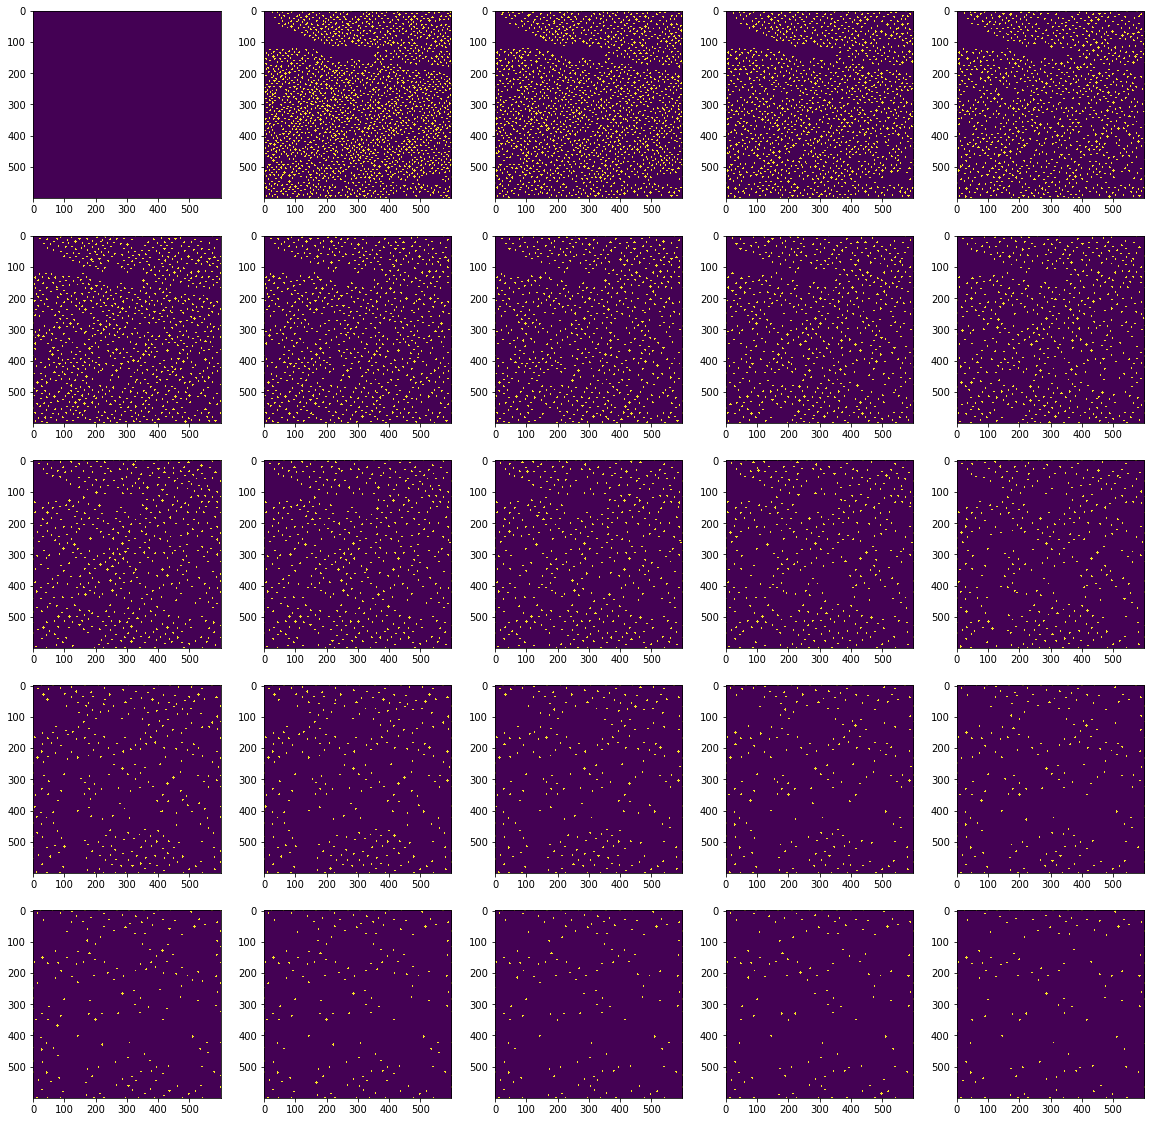

In [29]:
f, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = np.ravel(axes)
for b, ax in zip(SS_L, axes):
    _, maxs = find_min_max(b, 2, 0.2)
    min_max = (maxs) * 1
    min_max = ndimage.morphology.binary_dilation(min_max, iterations=3)
    ax.imshow(min_max)